# 0100 ベースラインモデル構築と評価
1. 多重共線性への対処：面積関連変数/フラグや古さ指標など、相関の高い変数が多いため、L2正則化が適切
2. 解釈のしやすさ：線形モデルやからモデルの解釈がしやすい。どの特徴量が重要かが係数から分かる
3. 計算効率：非線形モデルに比べて学習が速いから、素早く結果を確認できる
4. 過学習の防止：正則化パラメータαを調整することで、過学習を防げる

以上の利用から、Ridge回帰をベースラインモデルとして選定。

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from constants import *

plt.style.use('ggplot')
sns.set_palette('Set1_r')

## 0. データ取得から標準化まで

In [53]:
all_data = pd.read_csv(os.path.join(RAW_PATH, '0000_train_w_fs.csv'), index_col=0)
all_data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,log_TotalBsmtSF,log_GrLivArea,log_LotArea,log_total_sf,house_age,remod_age,yrs_before_remod,is_remodeled,built_era,year_price
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,6.753438,7.444833,9.042040,7.850493,5,5,0,0,post-2000,227387.363668
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,7.141245,7.141245,9.169623,7.833996,31,31,0,0,60-80,166794.831439
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,6.825460,7.488294,9.328212,7.903596,7,6,1,0,post-2000,223657.905932
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,6.629363,7.448916,9.164401,7.813592,91,36,55,0,1900-1940,124018.557143
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,7.044033,7.695758,9.565284,8.114923,8,8,0,0,80-2000,222266.190377


### 訓練と検証に使用するデータを作成
フラグと、すでに標準化されているものを除いて標準化

In [54]:
cols_to_scale = [
    'log_total_sf', # 立地、広さ（log）
    'house_age', 'remod_age', 'yrs_before_remod', 'year_price', # 古さに関する指標
    ] 

cols_not_scale = ['neighbor_log_price_stdscaled', 'has_2nd', 'has_bsmt', 'has_garage', 'has_pool',
                  'OverallQual_weight', 'OverallCond_weight', 'ExterQual_weight', 'ExterCond_weight', 'KitchenQual_weight'] # 設備のフラグ、スケール済み変数

data = all_data[cols_not_scale]

data_to_fit = all_data[cols_to_scale]

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

data[cols_to_scale] = scaler.fit_transform(data_to_fit)

target_log = all_data['log_price'] # 目的変数

data.head() # 説明変数

/var/folders/rk/9smfwdqx2cvdqr4qd3693stc0000gn/T/ipykernel_69741/3201168806.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[cols_to_scale] = scaler.fit_transform(data_to_fit)
/var/folders/rk/9smfwdqx2cvdqr4qd3693stc0000gn/T/ipykernel_69741/3201168806.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[cols_to_scale] = scaler.fit_transform(data_to_fit)
/var/folders/rk/9smfwdqx2cvdqr4qd3693stc0000gn/T/ipykernel_69741/3201168806.py:16: SettingWithCopyWarning: 
A value is trying to be set on a c

,neighbor_log_price_stdscaled,has_2nd,has_bsmt,has_garage,has_pool,OverallQual_weight,OverallCond_weight,ExterQual_weight,ExterCond_weight,KitchenQual_weight,log_total_sf,house_age,remod_age,yrs_before_remod,year_price
Id,,,,,,,,,,,,,,,
1,0.392476,1,1,1,0,0.491938,1.125140,0.473100,0.791019,0.421785,0.151951,-1.043259,-0.869941,-0.555742,0.875194
2,0.922961,0,1,1,0,0.136047,0.453155,-0.398789,0.791019,-0.545426,0.099298,-0.183465,0.390141,-0.555742,-0.333317
3,0.392476,1,1,1,0,0.491938,1.125140,0.473100,0.791019,0.421785,0.321443,-0.977121,-0.821476,-0.514873,0.800811
4,0.518880,1,1,1,0,0.491938,1.125140,-0.398789,0.791019,0.421785,0.034171,1.800676,0.632464,1.692084,-1.186486
5,1.897997,1,1,1,0,0.877136,1.125140,0.473100,0.791019,0.421785,0.995943,-0.944052,-0.724547,-0.555742,0.773053


## 1. モデル構築：Ridge回帰
### 説明変数と目的変数、訓練データと検証データに分割

In [55]:
from sklearn.model_selection import train_test_split

X = data
y_log = target_log

X_train, X_val_log, y_train, y_val_log = train_test_split(X, y_log, test_size=0.2, random_state=87)


In [56]:
from sklearn.linear_model import Ridge

alpha = 0.25

base_model_log = Ridge(alpha=alpha)

base_model_log.fit(X_train, y_train)

y_pred_log = base_model_log.predict(X_val_log)


from sklearn.metrics import root_mean_squared_error

log_rmse = root_mean_squared_error(y_val_log, y_pred_log)

print(log_rmse)

0.15463170308803326


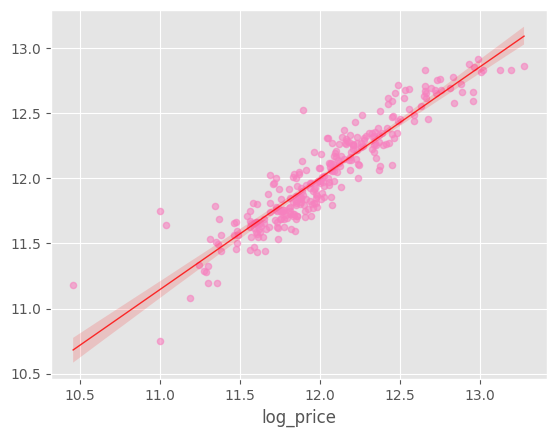

In [57]:
sns.regplot(x=y_val_log, y=y_pred_log, scatter_kws={'s': 20, 'alpha': 0.6}, line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
plt.show()


/Users/automatedtomato/github.com/automatedtomato/kaggle-house-prices/notebooks/utils/utils.py:96: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=importance, palette=colors)


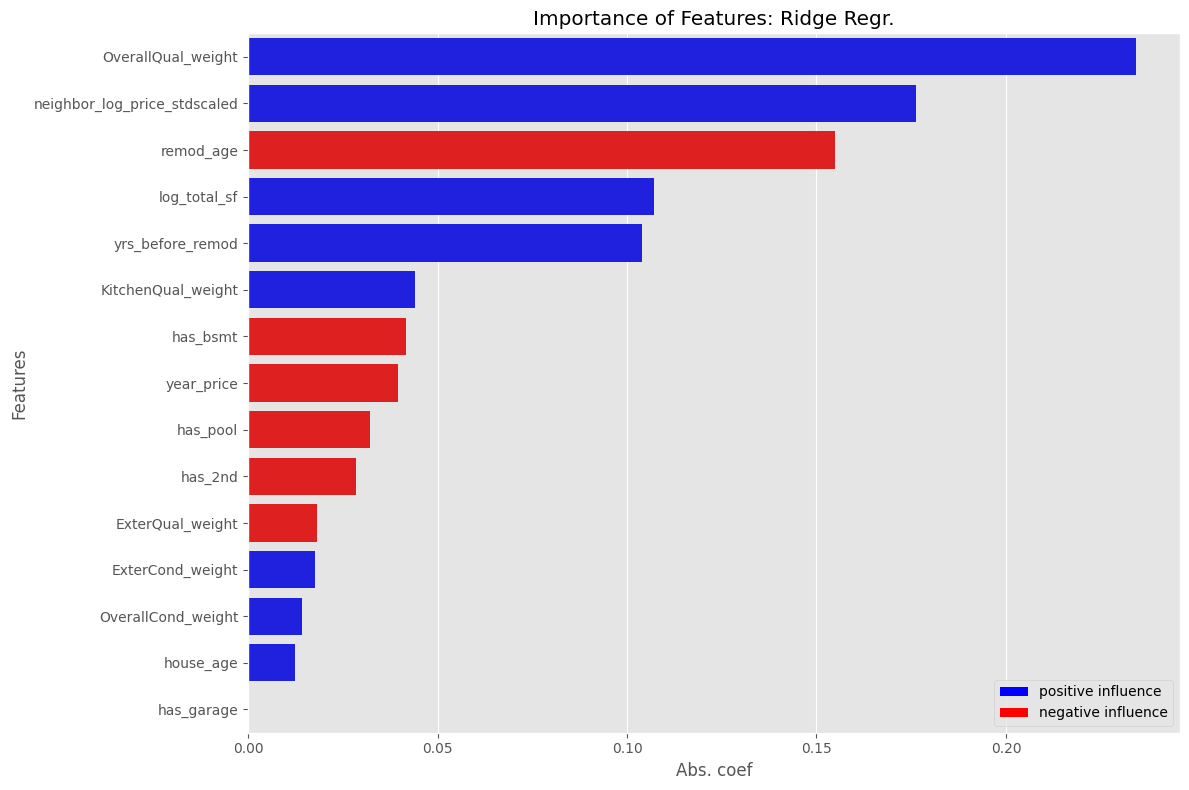

In [58]:
features = [
    'log_total_sf',
    'house_age', 'remod_age', 'yrs_before_remod', 'year_price',
    'OverallQual_weight', 'OverallCond_weight', 'ExterQual_weight', 'ExterCond_weight', 'KitchenQual_weight',
    'neighbor_log_price_stdscaled', 
    'has_2nd', 'has_bsmt', 'has_garage', 'has_pool'
    ]

from utils import plot_feature_importance

# 重要度プロット呼び出し
importance_df = plot_feature_importance(base_model_log, features, "Importance of Features: Ridge Regr.")

In [89]:
columns = importance_df['feature'].values

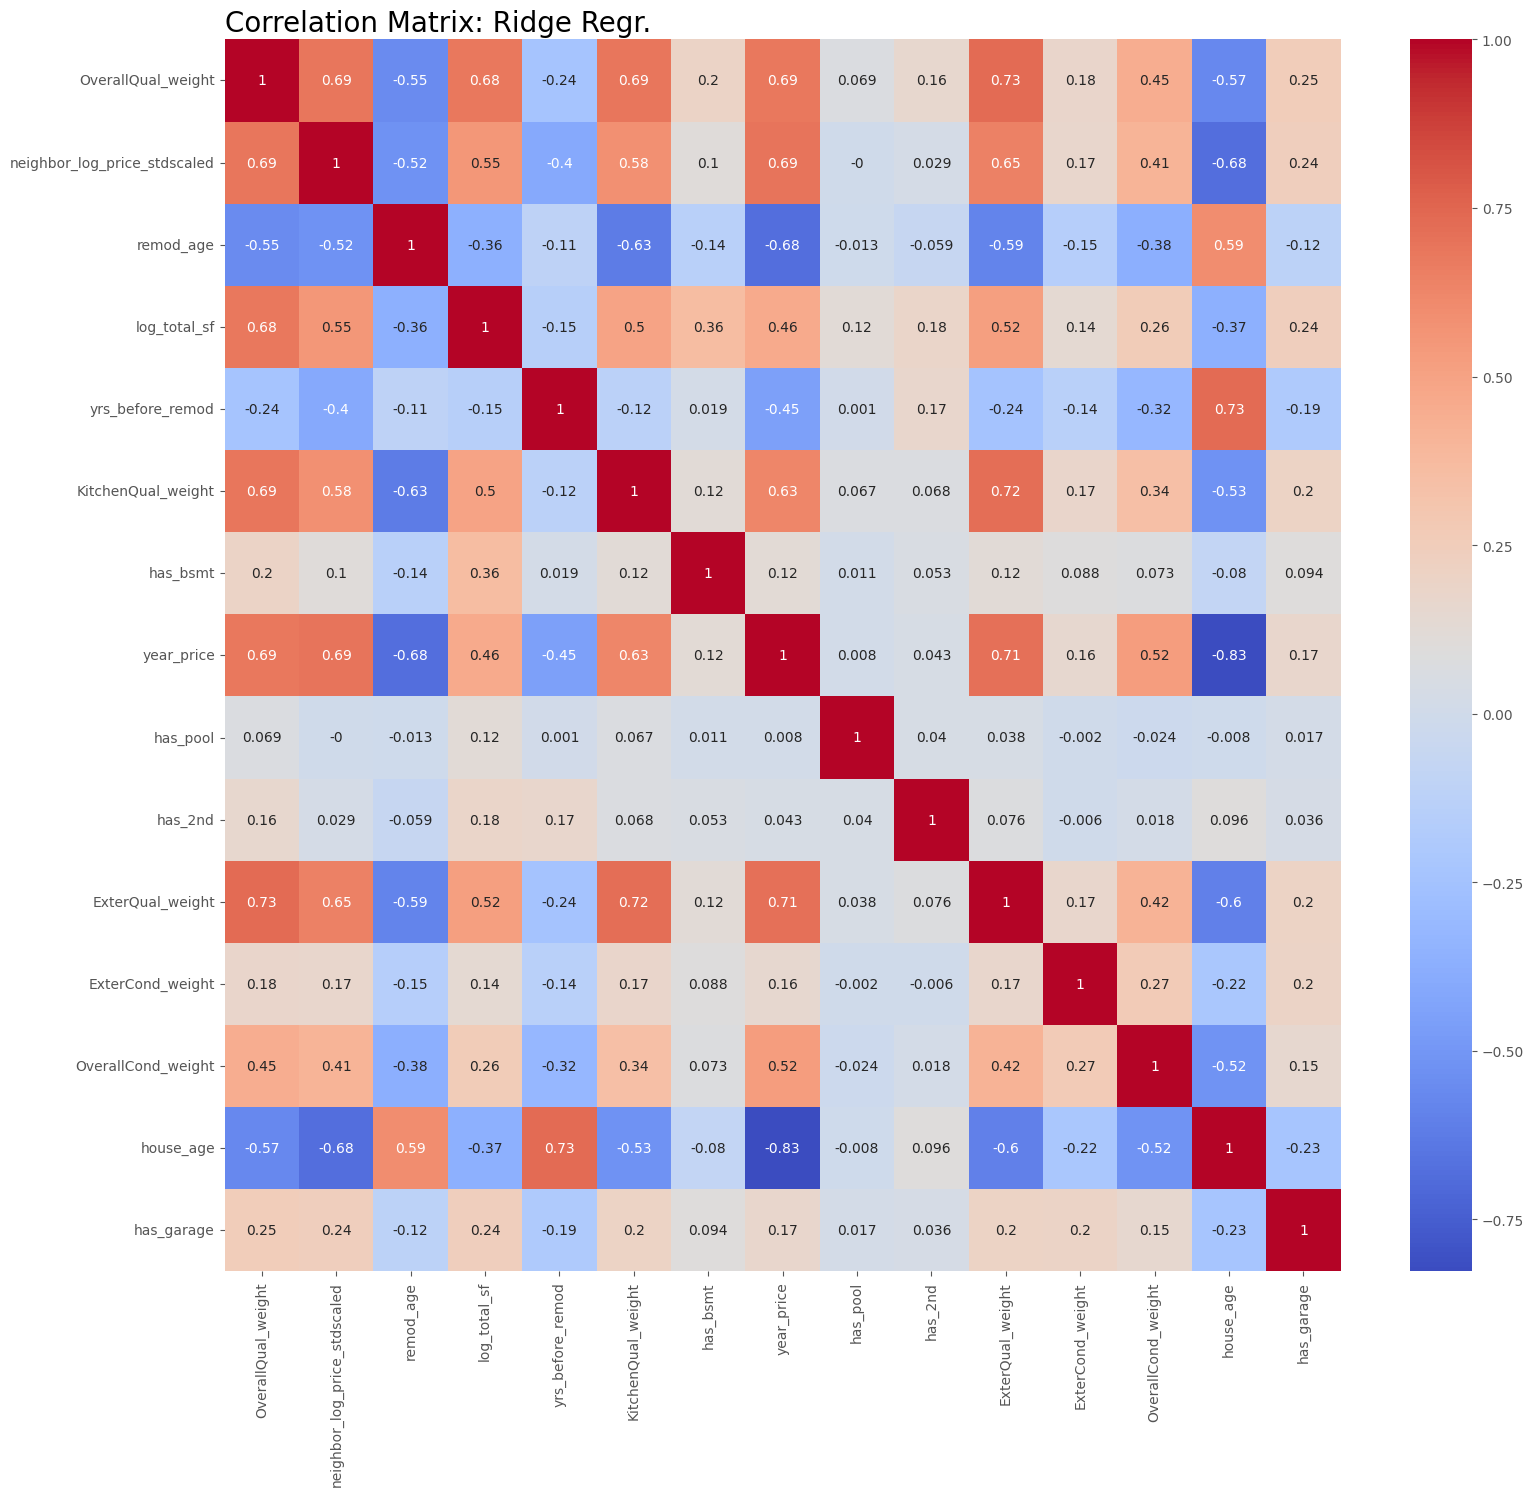

In [94]:
corr_mat = data[columns].corr().round(3)

plt.figure(figsize=(18, 16))
sns.heatmap(data=corr_mat, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix: Ridge Regr.', fontsize=20, loc='left')
plt.savefig(os.path.join(IMAGE_PATH, '0101_corr_matrix.png'))
plt.show()

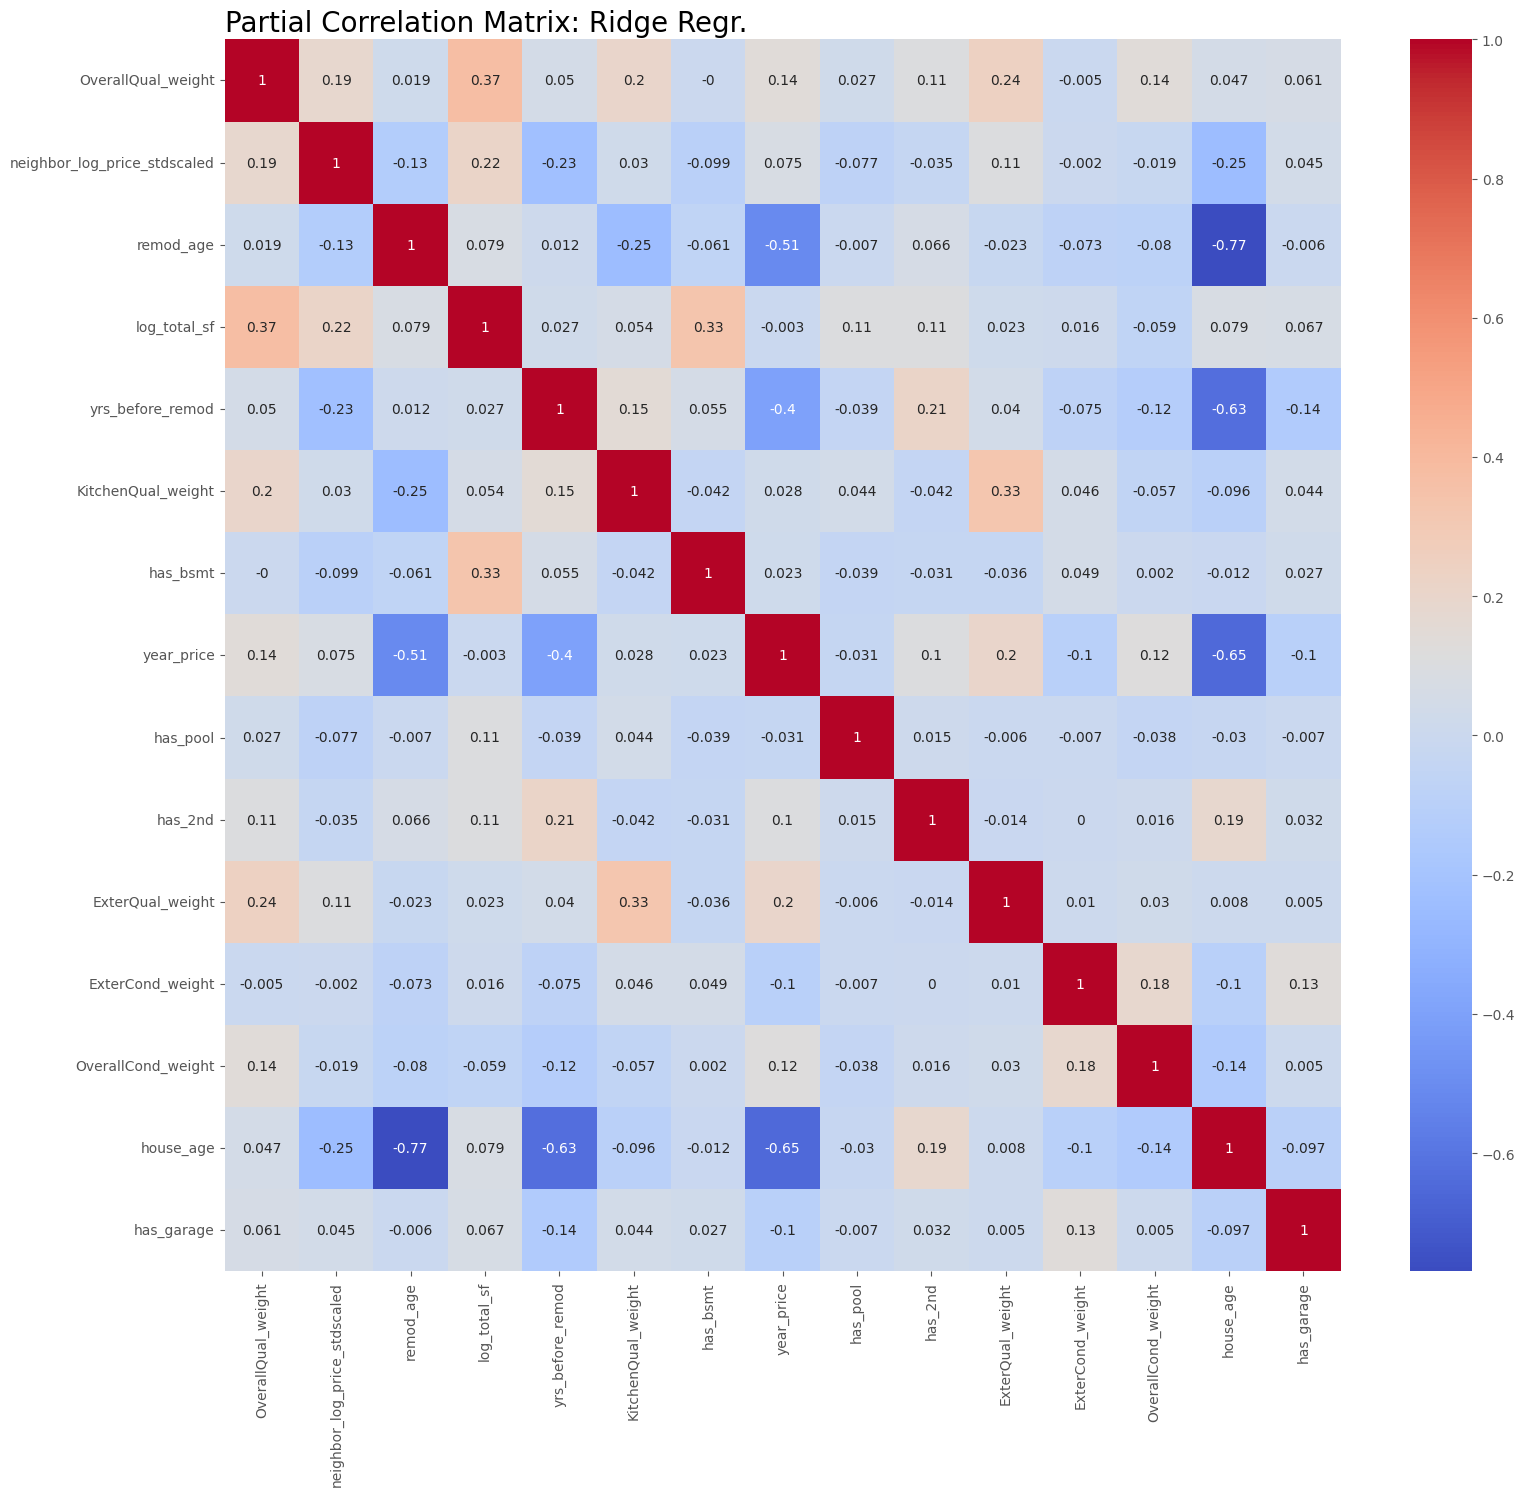

In [95]:
import pingouin as pg

pcorr_mat = pg.pcorr(data[columns]).round(3)

plt.figure(figsize=(18, 16))
sns.heatmap(data=pcorr_mat, annot=True, cmap='coolwarm')
plt.title('Partial Correlation Matrix: Ridge Regr.', fontsize=20, loc='left')
plt.savefig(os.path.join(IMAGE_PATH, '0102_pcorr_matrix.png'))
plt.show()